# 1 - Introduction

Name : Gilang Wiradhyaksa

Data : [AI Fruit and Real Fruit](https://www.kaggle.com/datasets/osmankagankurnaz/dataset-of-ai-generated-fruits-and-real-fruits/data)

# 2 - Import Libraries

In [35]:
# Import libraries

import os
import glob
import shutil
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import seaborn as sns
import tensorflow as tf
from pathlib import Path

from jmd_imagescraper.core import *

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

# 3 - Data Loading

In [8]:
# Listing images of each category

ai_files = glob.glob('dataset/ai/*')
real_files = glob.glob('dataset/real/*')

ai_files.sort()
real_files.sort()

# 4 - Exploratory Data Analysis

In [124]:
def random_sample(image_files, num_samples=5):
  random_files= random.sample(image_files, num_samples)
  return random_files

In [125]:
random_ai_fruit = random_sample(ai_files)
random_real_fruit = random_sample(real_files)

In [126]:
def visualize_img(random_data, labels=None):
  fig, axes= plt.subplots(1,5, figsize=(15,12))
  for i, image_path in enumerate(random_data):
    image = plt.imread(image_path)
    axes[i].imshow(image) # bisa tanpa cmap kalau bener2 RGB
    axes[i].set_title(f'{labels}, {image.shape}')
    axes[i].axis('off')
  plt.show()

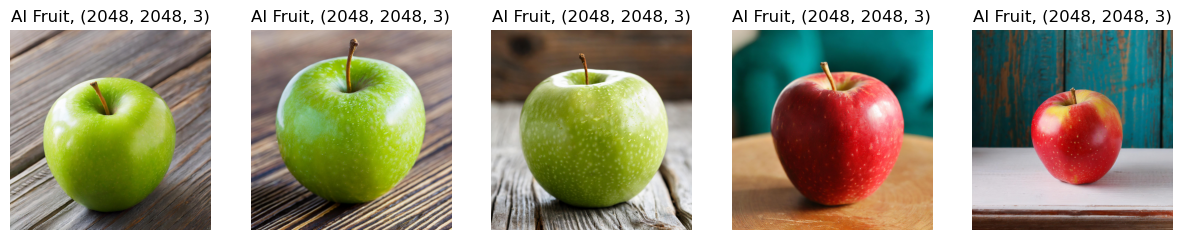

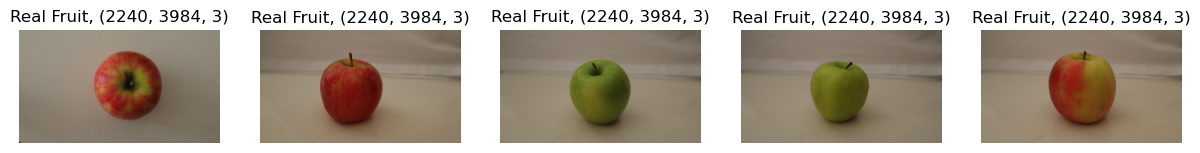

In [127]:
visualize_img(random_ai_fruit, "AI Fruit")
visualize_img(random_real_fruit, "Real Fruit")

# 5 - Feature Engineering

## 5.1 - Train, Test and Validation Split

In [51]:
# Define paths
dataset_path = "dataset"  # Total Data path colon_image_sets
train_output_path = "dataset/Train"  # Train data path
test_output_path = "dataset/Test"  # test data path
val_output_path = "dataset/Val"  # validation data path

# Create output directories if they don't exist
os.makedirs(train_output_path, exist_ok=True)
os.makedirs(test_output_path, exist_ok=True)
os.makedirs(val_output_path, exist_ok=True)

# List all the class directories in the dataset path
# class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
class_dirs = ['ai', 'real']

# Loop through each class directory and copy files to appropriate splits
for class_dir in class_dirs:
    # Create subdirectories in the output paths
    os.makedirs(os.path.join(train_output_path, class_dir), exist_ok=True)
    os.makedirs(os.path.join(test_output_path, class_dir), exist_ok=True)
    os.makedirs(os.path.join(val_output_path, class_dir), exist_ok=True)

    # List all the nested class directories (e.g., Red Apples, Green Apples)
    # nested_class_dirs = [nd for nd in os.listdir(os.path.join(dataset_path, class_dir)) if os.path.isdir(os.path.join(dataset_path, class_dir, nd))]

    # for nested_class_dir in nested_class_dirs:
        # Create subdirectories for each nested class directory
        # os.makedirs(os.path.join(train_output_path, class_dir, nested_class_dir), exist_ok=True)
        # os.makedirs(os.path.join(test_output_path, class_dir, nested_class_dir), exist_ok=True)
        # os.makedirs(os.path.join(val_output_path, class_dir, nested_class_dir), exist_ok=True)

        # List all image files in the nested class directory
        # files = glob.glob(os.path.join(dataset_path, class_dir, nested_class_dir, '*', '*.jpg'))
    files = glob.glob(os.path.join(dataset_path, class_dir, '*.jpg'))

    # Shuffle the files to ensure randomness
    random.shuffle(files)

    # Split the files into train, test, and validation sets
    total_samples = len(files)
    train_samples = int(0.7 * total_samples)
    test_samples = int(0.15 * total_samples)
    val_samples = total_samples - train_samples - test_samples

    train_files = files[:train_samples]
    test_files = files[train_samples:train_samples + test_samples]
    val_files = files[train_samples + test_samples:train_samples + test_samples + val_samples]

    # Copy files to the respective output directories
    for src_path in train_files:
        # dest_path = os.path.join(train_output_path, class_dir, nested_class_dir, os.path.basename(src_path))
        dest_path = os.path.join(train_output_path, class_dir, os.path.basename(src_path))
        shutil.copy(src_path, dest_path)

    for src_path in test_files:
        # dest_path = os.path.join(test_output_path, class_dir, nested_class_dir, os.path.basename(src_path))
        dest_path = os.path.join(test_output_path, class_dir, os.path.basename(src_path))
        shutil.copy(src_path, dest_path)

    for src_path in val_files:
        # dest_path = os.path.join(val_output_path, class_dir, nested_class_dir, os.path.basename(src_path))
        dest_path = os.path.join(val_output_path, class_dir, os.path.basename(src_path))
        shutil.copy(src_path, dest_path)

## 5.2 - Data Generator

In [52]:
# Image dimensions
img_width, img_height = 150, 150
input_shape = (img_width, img_height, 3)  # RGB images

In [53]:
# Data generators for RGB images with augmentation
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen_augmented = ImageDataGenerator(rescale=1./255)
validation_datagen_augmented = ImageDataGenerator(rescale=1./255)

In [55]:
# Generate augmented data for training
train_data_dir = 'dataset/Train'
test_data_dir = 'dataset/Test'
validation_data_dir = 'dataset/Val'

train_generator = train_datagen_augmented.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = 10,
    class_mode = 'categorical',
    classes = ['ai', 'real'],
    subset = 'training'
)

# Generate data for testing
test_generator = test_datagen_augmented.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=8,
    class_mode='categorical',
    shuffle=False,
    classes=['ai', 'real']
)

# Generate data for validation
validation_generator = validation_datagen_augmented.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=8,
    class_mode='categorical',
    shuffle=True,
    classes=['ai', 'real']
)

Found 273 images belonging to 2 classes.
Found 82 images belonging to 2 classes.
Found 85 images belonging to 2 classes.


In [56]:
class_indices = train_generator.class_indices
print(class_indices)

{'ai': 0, 'real': 1}


In [21]:
np.random.randint(len(train_generator.next()[0]), size=16)

array([7, 3, 5, 5, 6, 3, 5, 0, 9, 2, 1, 9, 7, 7, 7, 8])

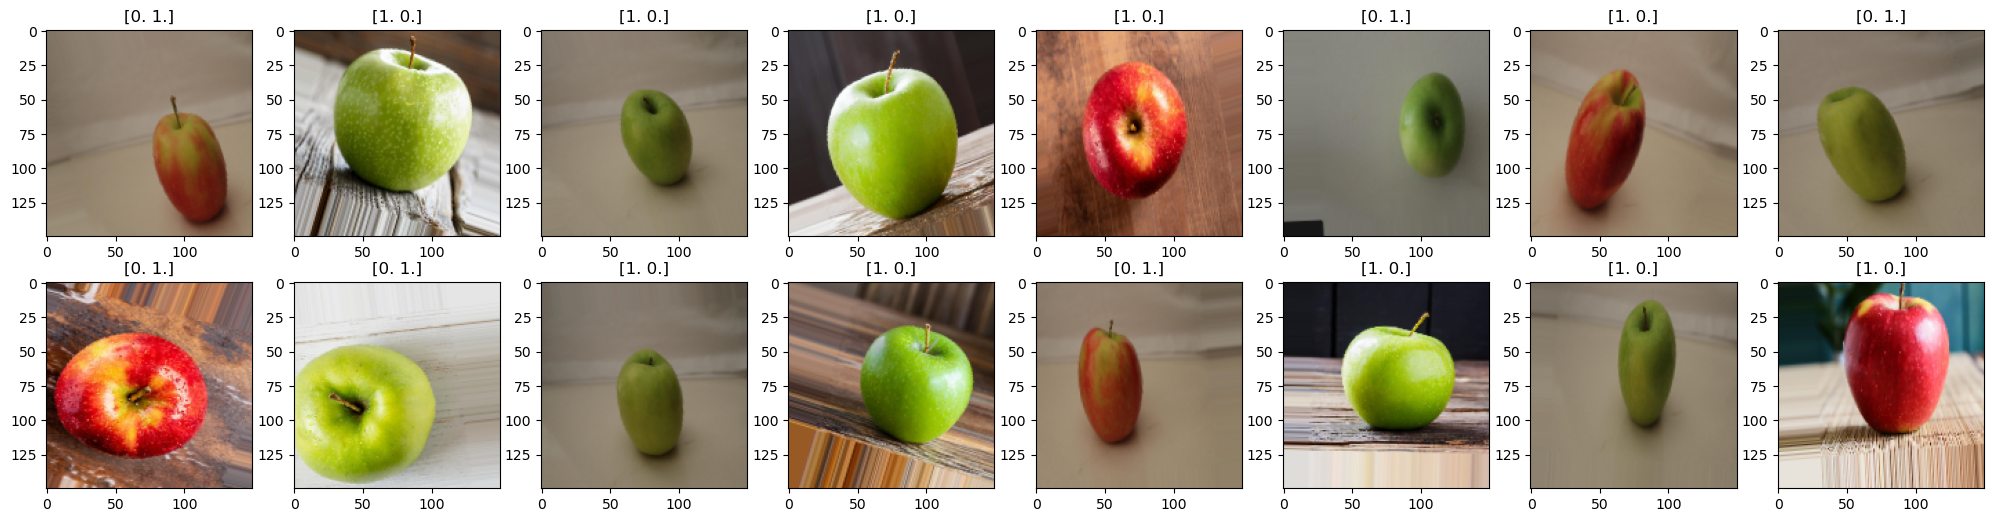

In [24]:
fig,ax = plt.subplots(nrows=2,ncols=8,figsize=(25,6))
n = 0
idx = np.random.randint(len(train_generator.next()[0]), size=16)
for i in range(2):
  for j in range(8):
    img = train_generator.next()[0][idx[n]]
    ax[i][j].imshow(img)
    ax[i][j].set_title(train_generator.next()[1][idx[n]])
    n+=1

# 6 - Model Definition & Training

## 6.1 Pooling

In [102]:
checkpoint_filepath_pooling = 'best_model_pooling.h5'
checkpoint_callback_pooling = ModelCheckpoint(
    filepath=checkpoint_filepath_pooling,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [106]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [107]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3),activation='relu', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Conv2D(128, (3,3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.GlobalAveragePooling2D()) ## Global Average Pooling 2D
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [108]:
model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [109]:
history = model.fit(train_generator, 
                    epochs=25, 
                    steps_per_epoch=20, 
                    validation_data=validation_generator, 
                    verbose=1, 
                    validation_steps=10, 
                    callbacks=[checkpoint_callback_pooling])

Epoch 1/25
20/20 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.5803
Epoch 1: val_loss improved from inf to 0.62591, saving model to best_model_pooling.h5
20/20 [==============================] - 17s 803ms/step - loss: 0.6848 - accuracy: 0.5803 - val_loss: 0.6259 - val_accuracy: 0.9250
Epoch 2/25
20/20 [==============================] - ETA: 0s - loss: 0.4593 - accuracy: 0.8497
Epoch 2: val_loss improved from 0.62591 to 0.16727, saving model to best_model_pooling.h5
20/20 [==============================] - 16s 810ms/step - loss: 0.4593 - accuracy: 0.8497 - val_loss: 0.1673 - val_accuracy: 0.9875
Epoch 3/25
20/20 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.9250
Epoch 3: val_loss improved from 0.16727 to 0.03872, saving model to best_model_pooling.h5
20/20 [==============================] - 16s 823ms/step - loss: 0.1933 - accuracy: 0.9250 - val_loss: 0.0387 - val_accuracy: 0.9875
Epoch 4/25
20/20 [==============================] - ETA:

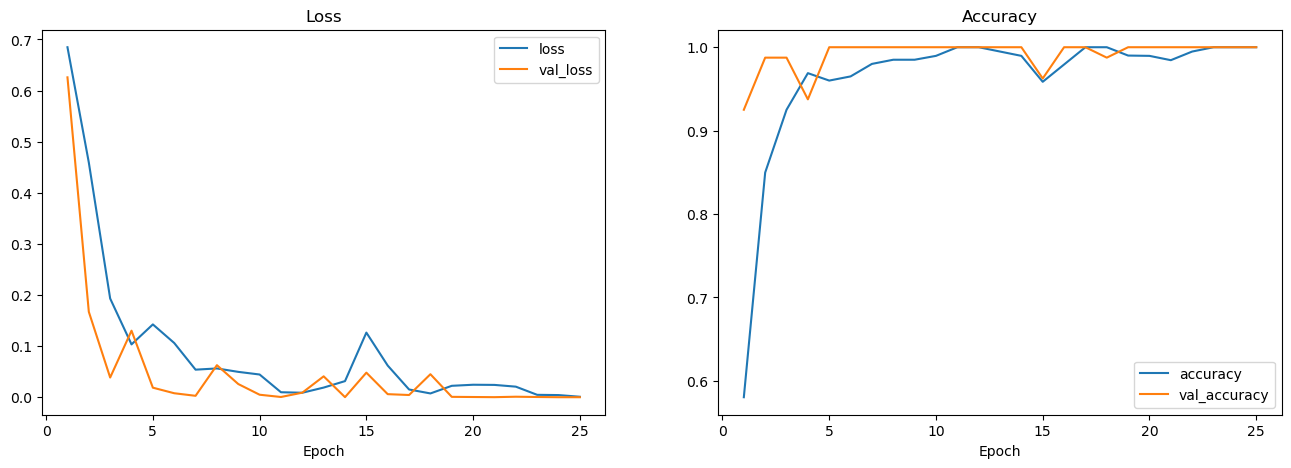

In [110]:
epoch=25

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

# 6.2 - Flatten

In [111]:
checkpoint_filepath_flatten = 'best_model_flatten.h5'
checkpoint_callback_flatten = ModelCheckpoint(
    filepath=checkpoint_filepath_flatten,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [112]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [113]:
model1 = tf.keras.models.Sequential()

model1.add(tf.keras.layers.Conv2D(32, (3,3),activation='relu', input_shape=(150, 150, 3)))
model1.add(tf.keras.layers.MaxPooling2D(2, 2))
model1.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(2, 2))
model1.add(tf.keras.layers.Conv2D(128, (3,3),activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(2, 2))
model1.add(tf.keras.layers.Flatten()) ## Flatten
model1.add(tf.keras.layers.Dropout(0.5))
model1.add(tf.keras.layers.Dense(512, activation='relu'))
model1.add(tf.keras.layers.Dense(2, activation='softmax'))

In [114]:
model1.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [115]:
history1 = model1.fit(train_generator, 
                      epochs=25, 
                      steps_per_epoch=20, 
                      validation_data=validation_generator, 
                      verbose=1, 
                      validation_steps=10, 
                      callbacks=[checkpoint_callback_flatten])

Epoch 1/25
20/20 [==============================] - ETA: 0s - loss: 0.9030 - accuracy: 0.6100
Epoch 1: val_loss improved from inf to 0.30327, saving model to best_model_flatten.h5
20/20 [==============================] - 18s 873ms/step - loss: 0.9030 - accuracy: 0.6100 - val_loss: 0.3033 - val_accuracy: 0.8750
Epoch 2/25
20/20 [==============================] - ETA: 0s - loss: 0.1679 - accuracy: 0.9400
Epoch 2: val_loss improved from 0.30327 to 0.04378, saving model to best_model_flatten.h5
20/20 [==============================] - 17s 864ms/step - loss: 0.1679 - accuracy: 0.9400 - val_loss: 0.0438 - val_accuracy: 0.9750
Epoch 3/25
20/20 [==============================] - ETA: 0s - loss: 0.1036 - accuracy: 0.9600
Epoch 3: val_loss improved from 0.04378 to 0.01432, saving model to best_model_flatten.h5
20/20 [==============================] - 17s 877ms/step - loss: 0.1036 - accuracy: 0.9600 - val_loss: 0.0143 - val_accuracy: 1.0000
Epoch 4/25
20/20 [==============================] - ETA:

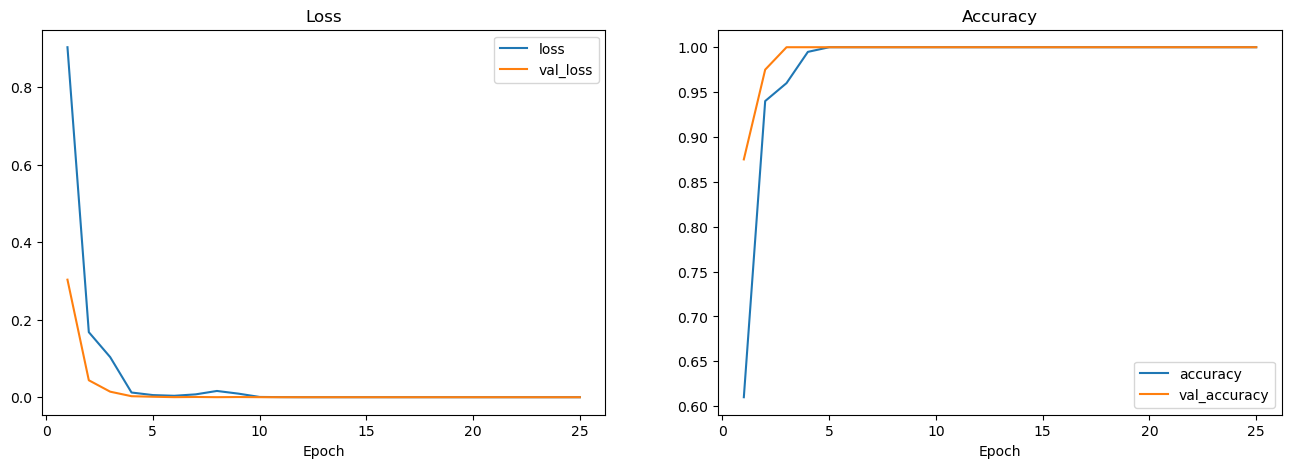

In [116]:
epoch=25

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history1.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history1.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history1.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history1.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

# 7 - Model Evaluation

In [117]:
load_model_pooling = load_model("best_model_pooling.h5")
load_model_flatten = load_model("best_model_flatten.h5")

## 7.1 - Pooling

In [118]:
# Predict labels for the test set
predictions = load_model_pooling.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

# Display some of the predicted and true classes
print("Predicted Classes:", predicted_classes[-10:])  # Display first 10 predicted classes
print("True Classes:", true_classes[-10:])  # Display first 10 true classes

11/11 [==============================] - 4s 360ms/step
Predicted Classes: [1 1 1 1 1 1 1 1 1 1]
True Classes: [1 1 1 1 1 1 1 1 1 1]


In [119]:
# print(classification_report(y_test.argmax(axis = 1), model.predict(X_test).argmax(axis = 1)))
print(classification_report(true_classes, predicted_classes, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        40
           1     1.0000    1.0000    1.0000        42

    accuracy                         1.0000        82
   macro avg     1.0000    1.0000    1.0000        82
weighted avg     1.0000    1.0000    1.0000        82



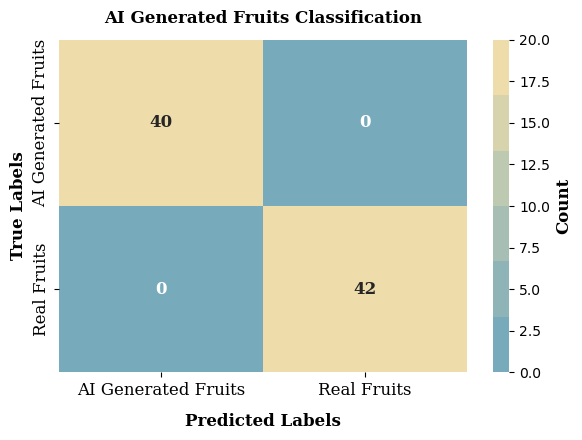

In [120]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4.5))
# Define the custom palette
custom_palette = sns.color_palette(palette='blend:#7AB,#EDA')# Modify the number based on number of classes in the dataset
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,vmin=0,vmax=20,
                      xticklabels=['AI Generated Fruits', 'Real Fruits'], yticklabels=['AI Generated Fruits', 'Real Fruits'],annot_kws={"family": "Serif",'weight': 'bold', 'size': 12})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font)
heatmap.set_ylabel('True Labels', fontdict=font)
heatmap.set_title('AI Generated Fruits Classification', fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.set_label('Count', fontdict=font)
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space
# Adjust layout to prevent cropping
plt.tight_layout()
plt.show()

## 7.2 - Flatten

In [121]:
# Predict labels for the test set
predictions1 = load_model_flatten.predict(test_generator)
predicted_classes1 = np.argmax(predictions1, axis=1)

true_classes1 = test_generator.classes

# Display some of the predicted and true classes
print("Predicted Classes:", predicted_classes1[-10:])  # Display first 10 predicted classes
print("True Classes:", true_classes1[-10:])  # Display first 10 true classes

11/11 [==============================] - 4s 353ms/step
Predicted Classes: [1 1 1 1 1 1 1 1 1 1]
True Classes: [1 1 1 1 1 1 1 1 1 1]


In [122]:
print(classification_report(true_classes1, predicted_classes1, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        40
           1     1.0000    1.0000    1.0000        42

    accuracy                         1.0000        82
   macro avg     1.0000    1.0000    1.0000        82
weighted avg     1.0000    1.0000    1.0000        82



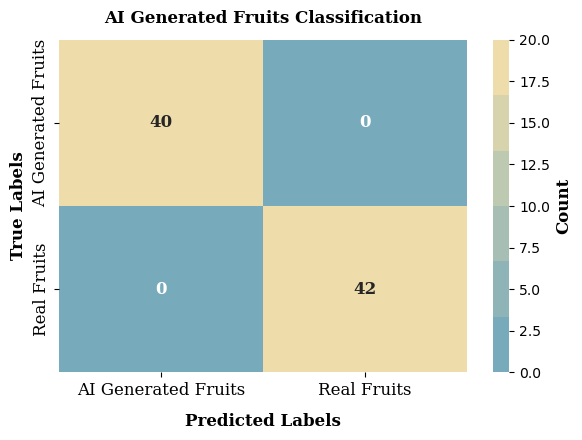

In [123]:
# Generate confusion matrix
conf_matrix1 = confusion_matrix(true_classes1, predicted_classes1)

# Plot confusion matrix
plt.figure(figsize=(6, 4.5))
# Define the custom palette
custom_palette = sns.color_palette(palette='blend:#7AB,#EDA')# Modify the number based on number of classes in the dataset
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap=custom_palette,vmin=0,vmax=20,
                      xticklabels=['AI Generated Fruits', 'Real Fruits'], yticklabels=['AI Generated Fruits', 'Real Fruits'],annot_kws={"family": "Serif",'weight': 'bold', 'size': 12})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font)
heatmap.set_ylabel('True Labels', fontdict=font)
heatmap.set_title('AI Generated Fruits Classification', fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.set_label('Count', fontdict=font)
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space
# Adjust layout to prevent cropping
plt.tight_layout()
plt.show()